In [51]:
import torch
from torch import nn
import uuid
from torchvision import transforms
import os
from PIL import Image
import torchvision
# import cv2
import numpy as np
from torch.utils.data import DataLoader        
from torch.utils.data import Dataset
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io  
import pandas as pd

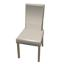

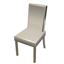

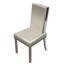

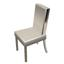

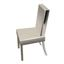

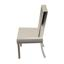

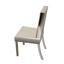

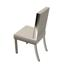

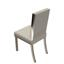

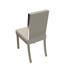

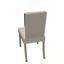

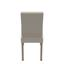

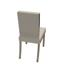

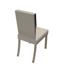

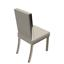

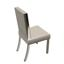

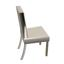

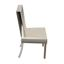

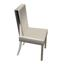

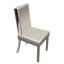

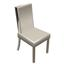

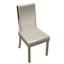

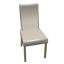

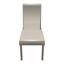

In [60]:
img = np.load('03001627_inputRGB/477fdfa65563f180f51f77a6d7299806.npy')

for i in range(img.shape[0]):
    display(Image.fromarray(img[i]))




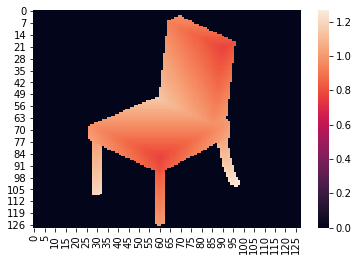

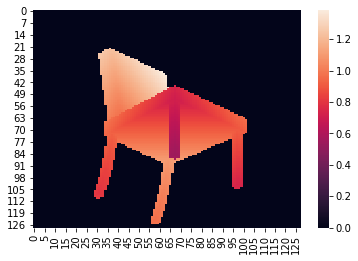

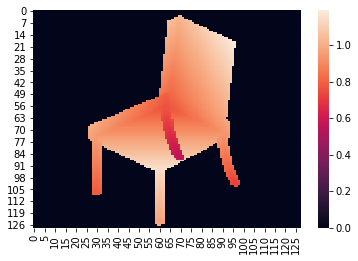

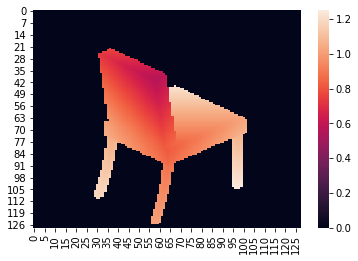

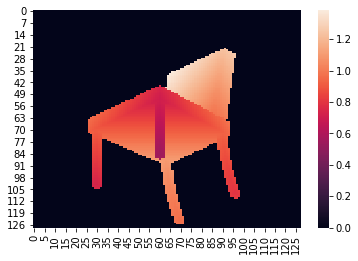

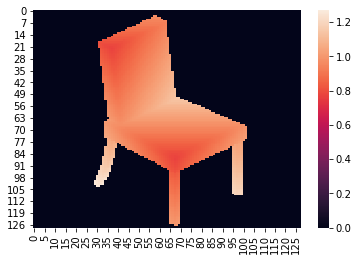

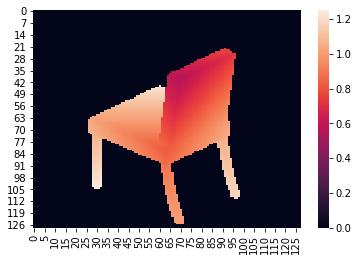

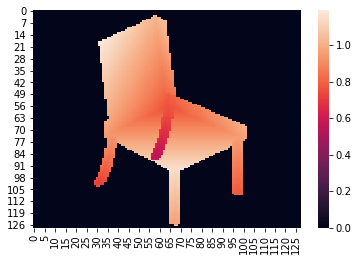

In [61]:
mat = scipy.io.loadmat('03001627_depth_fixed8/477fdfa65563f180f51f77a6d7299806.mat')['Z']
for i in range(mat.shape[0]):
    plt.figure()

    sns.heatmap(mat[i])


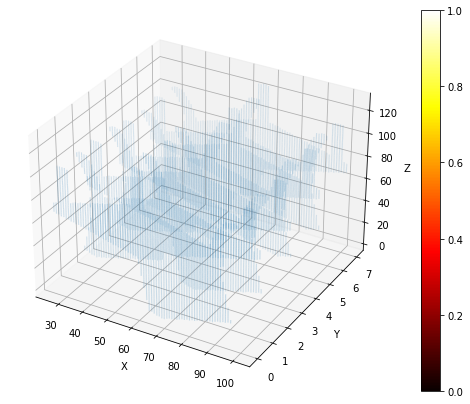

In [59]:
points = np.argwhere(mat != 0)
xs = points[:,0]
ys = points[:,1]
zs = points[:,2]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(zs, xs, ys, cmap=plt.hot(),marker='o',s=0.01)
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [5]:

class resenet_block(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels,channels,3,padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels,channels,3,padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self,x):
        y = self.conv1(x)
        y = nnf.relu(self.bn1(y))
        y = self.conv2(y)
        y = nnf.relu(self.bn2(x+y))
        return y

def resnet_encoder(in_channels, output_dimension=1,downscale_architecture='resnet34'):
    downscale_architecture = downscale_architecture
    model_layers = []
    if downscale_architecture == 'resnet34':
        downscale_architecture = [3,3,5,3]

    model_layers.append(nn.Conv2d(in_channels,64,7,padding=3))
    model_layers.append(nn.BatchNorm2d(64))
    model_layers.append(nn.ReLU())
    #add relu
    model_layers.append(nn.MaxPool2d(3,stride=2,padding=1))
    in_channels = 64



    for count,resnet_section_length in enumerate(downscale_architecture):
        for i in range(resnet_section_length):
            model_layers.append(resenet_block(in_channels))
        if count < (len(downscale_architecture)-1):
            model_layers.append(nn.Conv2d(in_channels,in_channels*2,kernel_size=3,stride=2,padding=1))
            in_channels = in_channels*2
            model_layers.append(nn.BatchNorm2d(in_channels))
            model_layers.append(nn.ReLU())
            model_layers.append(nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=1,padding=1))
            model_layers.append(nn.BatchNorm2d(in_channels))
            model_layers.append(nn.ReLU())

    model_layers.append(nn.AdaptiveAvgPool2d((1,1)))
    #add flatten
    model_layers.append(nn.Flatten())
    model_layers.append(nn.Linear(in_channels,1024))
    model_layers.append(nn.ReLU())
    model_layers.append(nn.Linear(1024,1024))
    model_layers.append(nn.ReLU())

    model = nn.Sequential(*model_layers)
    return model
 
    
class Decoder(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv1 = torch.nn.ConvTranspose2d(16,16,kernel_size=4, stride=2, padding=1) #16
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.ConvTranspose2d(16,8,kernel_size=4, stride=2, padding=1)#32
        self.bn3 = torch.nn.BatchNorm2d(8)
        self.conv3 = torch.nn.ConvTranspose2d(8,8,kernel_size=4, stride=2, padding=1)#64
        self.bn4 = torch.nn.BatchNorm2d(8)
        self.conv4 = torch.nn.ConvTranspose2d(8,8,kernel_size=4, stride=2, padding=1)#128
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = torch.reshape(x, (x.shape[0],16,8,8))
        x = self.bn1(x)
        x = self.relu(self.bn2(self.conv1(x)))
        x = self.relu(self.bn3(self.conv2(x)))
        x = self.relu(self.bn4(self.conv3(x)))
        x = self.conv4(x)
        
        return x
        

    
    
class pointcloud_model(nn.Module):
    def __init__(self,enc,dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
        
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [6]:
enc = resnet_encoder(3,1024)
dec = Decoder(1024)
net = pointcloud_model(enc,dec)
net(torch.ones((32,3,128,128))).shape

torch.Size([32, 8, 128, 128])

In [16]:
def train(model,train_set,optimizer,criterion_loss,validation_set=None,batch_size=32,device='cpu',epochs=10):
        model.to(device)
        criterion_loss.to(device)
        model.train()
#         train_set.change_device(device)
        train_dataloader = DataLoader(train_set,batch_size=batch_size)
        if validation_set:
#             validation_set.change_device(device)
            validation_dataloader = DataLoader(validation_set,batch_size=batch_size)
            
        history={'train_loss':[],
                'validation_loss':[]}
        
        for epoch in range(epochs):
            train_loss = []
            for i, data in enumerate(train_dataloader):

                x = data[0].to(device)
                y = data[1].to(device)

                model.zero_grad()

                y_pred = model(x)
                loss = criterion_loss(y_pred,y)
                train_loss.append(loss.item())

                loss.backward()
                optimizer.step()  
            
            mean_loss = np.mean(train_loss)
            history['train_loss'].append(mean_loss)
            metric_string = 'epoch - %s : training loss - %s' % (epoch, str(mean_loss))
            
            if validation_set:
                val_loss = []
                with torch.no_grad():
                    for i, data in enumerate(validation_dataloader):

                        x = data[0].to(device)
                        y = data[1].to(device)

                        y_pred = model(x)
                        loss = criterion_loss(y_pred,y)
                        val_loss.append(loss.item())
                        
                mean_loss = np.mean(val_loss)
                history['validation_loss'].append(mean_loss)
                metric_string = ' : '.join([metric_string,'validation loss - %s' % str(mean_loss)])
            print(metric_string)
                
        return history

In [44]:
from torch.utils.data import Dataset

class Custom_dset(Dataset):#torchvision.datasets.Vision
    def __init__(self,files,file_batch_size=32):
        super().__init__()
        self.imgs = []
        rgb = []
        depth = []
        count = 0
        for filename in files:
            if count == file_batch_size:
                break
                
            if filename[0][-4:] == '.npy':
                rgb.append(np.load(filename[0]))
                depth.append(np.stack([scipy.io.loadmat(filename[1])['Z']]*len(rgb)))
                count += 1 
        
        self.data = torch.Tensor(np.stack(rgb))
        self.label = torch.Tensor(np.concatenate(depth))
        
    def __len__(self):
        return (self.data.shape[0])
        
    def __getitem__(self,idx):
        return [self.data[idx,:], self.label[idx,:]]
    
    
def get_datasets(rgb_dir, fixed_depth_dir,transforms=None,test_val_transforms=None,test_train_split=0.1,val_train_split=0.1):
    
    files = []
    
    depth_list_dict = {}
    depth_list = os.listdir(fixed_depth_dir)
    for filename in depth_list:
        depth_list_dict[filename[:-3]] = os.path.join(fixed_depth_dir,filename)
        
    rgb_list = os.listdir(rgb_dir)
    for filename in rgb_list:
        if filename[:-3] in depth_list_dict:
            files.append([os.path.join(rgb_dir,filename),os.path.join(fixed_depth_dir,filename[:-3] +'mat')])
    
#     print(files)
    test_files = files[:int(test_train_split*len(files))]
    train_files = files[int(test_train_split*len(files)):]    
    val_files = train_files[:int(val_train_split*len(train_files))]
    train_files = train_files[int(val_train_split*len(train_files)):]
    
    train_set = Custom_dset(train_files)
    val_set = Custom_dset(val_files)
    test_set = Custom_dset(test_files)
    
    return train_set, val_set, test_set    
    
    



In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device - ' + device)
train_dset, val_dset, test_dset = get_datasets('03001627_inputRGB','03001627_depth_fixed8')
criterion_loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)
history = train(net,train_set,optimizer,criterion_loss,device=device,validation_set=val_set,epochs=20,batch_size=10)

Device - cuda
epoch - 0 : training loss - 1.2901326233986766e-05 : validation loss - 4.767590428855328e-06
epoch - 1 : training loss - 3.7109813674760516e-06 : validation loss - 2.409487193290261e-06
epoch - 2 : training loss - 2.625932840373935e-06 : validation loss - 1.7732562077981129e-06
epoch - 3 : training loss - 2.0358075810236186e-06 : validation loss - 1.0277146386670212e-06


KeyboardInterrupt: 